# Pruebas para generar Training

In [120]:
from tqdm import tqdm
import pickle
from sklearn.cluster import dbscan
import sys
sys.path.insert(0, 'other/')
from TrackML.dataset import load_event
import numpy as np 
import pandas as pd 
from functions.others import calc_features, score_event_fast, tag_bins

In [121]:
min_hits=4
train_path='data/train_100_events/'    #Path to traning data
clustered_path = 'clustering/' #path to solutions
solution_sufix = '_cluster' #the solution files prefix
num_train=90
num_val=10

In [122]:
def save_obj(obj, filename):
    with open(filename, 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)
        
def load_obj(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)


In [123]:
def hit_score(res, truth):
    tt = res.merge(truth[['hit_id', 'particle_id', 'weight']], on='hit_id', how='left')
    _, tt['track_len'] = tag_bins(tt['track_id'])
    _, tt['real_track_len'] = tag_bins(tt['particle_id'])
    gp = tt.groupby('track_id')['particle_id'].value_counts().rename('par_freq').reset_index()
    tt = tt.merge(gp, on=['track_id', 'particle_id'], how='left')
    gp = gp.groupby(by='track_id').head(1)
    gp = gp.rename(index=str, columns={'particle_id': 'common_particle_id'})
    tt = tt.merge(gp.drop(['par_freq'], axis=1), on='track_id', how='left')
    tt['to_score'] = (2*tt['par_freq'] > tt['track_len']) & (2*tt['par_freq'] > tt['real_track_len'])
    tt['score'] = tt['weight'] * tt['to_score']
    return tt

In [124]:
def get_features(sub, cluster_size=10):
    hitst = sub.copy()
    X = np.column_stack([hitst.x.values, hitst.y.values, hitst.z.values, hitst.track_id.values*1000000])
    _, hitst['labels'] = dbscan(X, eps=cluster_size, min_samples=1, algorithm='ball_tree', metric='euclidean')
    gp = hitst.groupby('track_id').agg({'hit_id': 'count', 'labels': 'nunique', 'volume_id': 'min',
                                        'x': ['min', 'max', 'var'], 'y': ['min', 'max', 'var'], 'z': ['min', 'max', 'var', 'mean']})
    gp.columns = ["".join(t) for t in gp.columns.ravel()]
    gp = gp.rename(columns={'hit_idcount': 'nhits', 'labelsnunique': 'nclusters', 'volume_idmin': 'svolume'})
    gp['nhitspercluster'] = gp.nhits / gp.nclusters
    return gp

In [125]:
def get_true_tracks(hits, particles, truth, min_hits = 4):
    hitst = hits.merge(truth[['hit_id', 'particle_id']], on='hit_id', how='left')
    hitst = hitst.merge(particles[['particle_id', 'nhits']])
    hitst = hitst[hitst.nhits > min_hits].rename(columns={'particle_id': 'track_id'})
    d = get_features(hitst)
    return d[['svolume', 'nhits', 'nclusters', 'nhitspercluster', 'xmax', 'ymax', 'zmax',
                'xmin', 'ymin', 'zmin', 'zmean', 'xvar', 'yvar', 'zvar']]

In [126]:
df_all_subs = pd.DataFrame()
trues = []
wrongs = []

for i in tqdm(range(num_train + num_val)):
    event = 'event000001{:03d}'.format(i)
    hits, cells, particles, truth = load_event(train_path + event)
    sub = pd.read_csv('{}{}{}.csv'.format(clustered_path, event, solution_sufix))
    ssub = hit_score(sub, truth)
    gp = ssub.groupby('track_id').agg({'score':'sum', 'weight': 'sum', 'track_len': 'max'}).reset_index()
    ssub = ssub[['hit_id', 'track_id']].merge(gp, on='track_id')
    ssub = ssub[((ssub.score == 0) | (ssub.score < ssub.weight)) & (ssub.track_len > 4)][['hit_id', 'track_id']]
    ssub = ssub.merge(hits, on='hit_id', how='left')
    df_wrong = get_features(ssub)
    df_wrong = df_wrong[['svolume', 'nhits', 'nclusters', 'nhitspercluster', 'xmax', 'ymax', 'zmax',
                         'xmin', 'ymin', 'zmin', 'zmean', 'xvar', 'yvar', 'zvar']]
    df_wrong['target'] = 0
    
    df_true = get_true_tracks(hits, particles, truth)
    df_true['target'] = 1
    df_true = df_true.sample(frac=0.35)
    
    trues.append(df_true.shape[0])
    wrongs.append(df_wrong.shape[0])
    
    df_both = pd.concat([df_true, df_wrong], ignore_index=True).sample(frac=1).reset_index(drop=True)
    df_both['event_id'] = i 
    df_all_subs = df_all_subs.append(df_both, ignore_index=True)
    
df_train = df_all_subs[df_all_subs['event_id'] > num_val]
df_test = df_all_subs[df_all_subs['event_id'] <= num_val]

save_obj(df_train, 'training/pro_train.pkl')
save_obj(df_test, 'training/pro_test.pkl')

100%|██████████| 100/100 [01:48<00:00,  1.08s/it]


In [127]:
import matplotlib.pyplot as plt 
%matplotlib inline

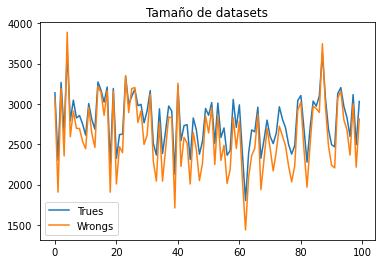

In [128]:
plt.plot(trues, label='Trues')
plt.plot(wrongs, label='Wrongs')
plt.legend()
plt.title('Tamaño de datasets')
plt.show()